# TAIS - MinC
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaX3LNhGcAe1HnPZSuWS0oH6af0LJHXcH7If1sQgLCFAT1chNGFg)

This notebook is going to be the basis for my workshop at the PyData 2018 Amsterdam workshop. If you have any questions, please let me know!

You'll build a relatively simple bot, that just asks you about your mood and tries to cheer you up if you're feeling a bit down. 

The tutorial consists of three parts:


*   Part 0: Installation and preparations
*   Part 1: You'll start with a basic bot that can only understand natural language but no dialogues.
*   Part 2: You'll add the abilitiy to understand multiturn dialogues.
*   Part 3: I'll give you further resources so you can extend this simple demo.


## Part 0: Installation

### Let's start with jupyter configuration

In [4]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Installation of Rasa
First you'll have to install Rasa Core and NLU in this notebook if you already have them installed in your env, you can just skip this. 

In [3]:
import sys
python = sys.executable

# In your environment run:
!{python} -m pip install -r requirements.txt


spacy 2.0.16 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ipython 6.4.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 1.0.14 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Let's check if the correct versions are installed (should be rasa_nlu: 0.12.3 rasa_core: 0.9.0a7) and the spacy model is available:

In [2]:
import rasa_nlu
import rasa_core

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))


rasa_nlu: 0.13.5 rasa_core: 0.11.12


### Some additional Tools needed
To do some of the visualizations you will also need graphviz. If you don't have graphviz installed, and this doesn't work: don't worry. I'll show you the graph and besides that visualization everything else will work.

Try installing with anyone of these (or adapt to your operating system):

In [5]:
!{python} -m pip install graphviz;

spacy 2.0.16 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ipython 6.4.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 1.0.14 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Train the Rasa NLU Model

You're going to train a model to recognise these intents, so that when you send a message like "hello" to your bot, it will recognise this as a `"greet"` intent.

In [8]:
!{python} bot.py train-nlu

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
:0: UserWarning: You do not have a working installation of the service_identity module: 'No module named 'service_identity''.  Please install it from <https://pypi.python.org/pypi/service_identity> and make sure all of its dependencies are satisfied.  Without the service_identity module, Twisted can perform only rudimentary TLS client hostname verification.  Many valid certificate/hostname mappings may be rejected.
2018-11-04 18:59:07 INFO     rasa_nlu.training_data.loading  - Training data format of bot/data/intents/processo.md is md
2018-11-04 18:59:07 INFO     rasa_nlu.training_data.training_data  - Training data stats: 
	- intent examples: 327 (13 distinct intents)
	- Found intents: 

### Use & evaluate the NLU model
Let's play around with the model and shoot it some messages:

In [ ]:
pprint(interpreter.parse("doing great"))

Instead of evaluating it by hand, the model can also be evaluated on a test data set (though for simplicity we are going to use the same for test and train):

/anaconda3/lib/python3.6/site-packages/rasa_nlu/extractors/entity_synonyms.py:85: UserWarning: Failed to load synonyms file from 'bot/models/nlu/default/current/entity_synonyms.json'
  "".format(entity_synonyms_file))


INFO:tensorflow:Restoring parameters from bot/models/nlu/default/current/intent_classifier_tensorflow_embedding.ckpt


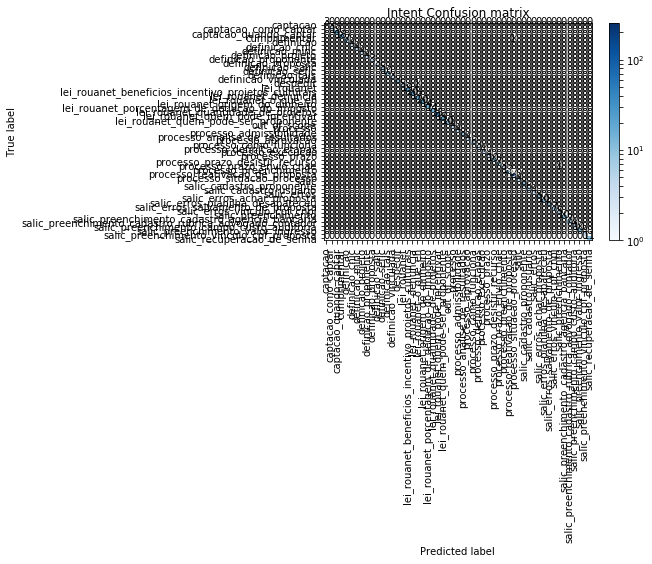

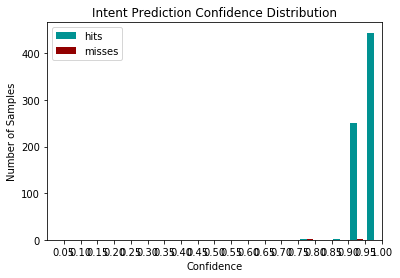

In [2]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("bot/data/intents/", "bot/models/nlu/default/current")

# Part 2: Adding dialogue capabilities

### Writing Stories

A good place to start is by writing a few stories. These are example conversations that Rasa Core will learn from. 

The format works like this:

A story starts with `##` and you can give it a name. 
lines that start with `*` are messages sent by the user. Although you don't write the *actual* message, but rather the intent (and the entities) that represent what the user *means*. If you don't know about intents and entities, don't worry! We will talk about them more later. 
Lines that start with `-` are *actions* taken by your bot. In this case all of our actions are just messages sent back to the user, like `utter_greet`, but in general an action can do anything, including calling an API and interacting with the outside world. 

In [ ]:
stories_md = """
## happy path               <!-- name of the story - just for debugging -->
* greet              
  - utter_greet
* mood_great               <!-- user utterance, in format intent[entities] -->
  - utter_happy
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_goodbye
  
## sad path 1               <!-- this is already the start of the next story -->
* greet
  - utter_greet             <!-- action the bot should execute -->
* mood_unhappy
  - action_retrieve_image
  - utter_cheer_up
  - utter_did_that_help
* mood_affirm
  - utter_happy

## sad path 2
* greet
  - utter_greet
* mood_unhappy
  - action_retrieve_image
  - utter_cheer_up
  - utter_did_that_help
* mood_deny
  - utter_goodbye
  
## strange user
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_unclear

## say goodbye
* goodbye
  - utter_goodbye

## fallback
- utter_unclear

"""

%store stories_md > stories.md

### Defining a Domain

The domain specifies the universe that your bot lives in. You should list all of the intents and actions that show up in your stories. 
This is also the place to write templates, which contain the messages your bot can send back

In [ ]:
domain_yml = """
intents:
- greet
- goodbye
- mood_affirm
- mood_deny
- mood_great
- mood_unhappy

slots:
  img_api_response:
    type: unfeaturized

actions:
- utter_greet
- utter_cheer_up
- utter_did_that_help
- utter_happy
- utter_goodbye
- utter_unclear
- __main__.ApiAction

templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_cheer_up:
  - text: "Here is something to cheer you up: {img_api_response}"

  utter_did_that_help:
  - text: "Did that help you?"

  utter_unclear:
  - text: "I am not sure what you are aiming for."
  
  utter_happy:
  - text: "Great carry on!"

  utter_goodbye:
  - text: "Bye"
"""

%store domain_yml > domain.yml

### Adding Custom API methods

Sometimes, you not only want to send back messages to the user, but you also want to call an API or run some code. YOu can create custom actions that will be called once the bots ML model predicts them. You'll use that to fetch a random image from a remote server (we are not actually fetching it here, but we could ;)

In [ ]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet

import requests

class ApiAction(Action):
    def name(self):
        return "action_retrieve_image"

    def run(self, dispatcher, tracker, domain):
        dispatcher.utter_message("looking for a good img")
        url = "https://picsum.photos/200/300/?random"
        return [SlotSet("img_api_response", url)]  

### Pro Tip: Visualising the Training Data

You can visualise the stories to get a sense of how the conversations go. This is usually a good way to see if there are any stories which don't make sense


In [ ]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent('domain.yml')
agent.visualize("stories.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

### Training your Dialogue Model

Now comes the fun part! We're going to show Rasa Core the stories we wrote above, and train a model on these examples. 
In this case, the model is a neural network implemented in Keras which learns to predict which action to take next. 

In [ ]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.6)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=400
)

agent.persist('models/dialogue')

### Starting up the bot (with NLU)

Now that we've trained the dialogue **and** language understanding models and saved them, we can start up an `Agent` which will handle conversations for us. 

In [ ]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

### Talking to the Bot (with NLU)

We can start talking to the bot in natural language.

In [ ]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])


### Evaluation of the dialogue model
As with the NLU model, instead of just subjectively testing the model, we can also evaluate the model on a dataset. You'll be using the training data set again, but usually you'd use a test data set separate from the training data.

In [ ]:
from rasa_core.evaluate import run_story_evaluation

run_story_evaluation("stories.md", "models/dialogue", 
                     nlu_model_path=None, 
                     max_stories=None, 
                     out_file_plot="story_eval.pdf")

### Interactive learning
Unfortunately, this doesn't work in jupyter yet. Hence, we going to do this on the command line. [The repository](https://github.com/tmbo/rasa-demo-pydata18)  contains a makefile with the instructions to run the interactive learning. So go ahead and run `make interactive` on the commandline (make sure your shell is in the righht virtual env).

# Part 3: Next steps

Great job! You've built your first bot that uses Machine Learning to manage dialogues. As a next step, we'd suggest you start building your own bot. Here are a few useful links:



*   Install the Rasa Stack on your machine [here](https://core.rasa.ai/installation.html)
*   Checkout more of the Docs: [NLU](https://nlu.rasa.com) and [Core](https://core.rasa.com)
*   Connect to the community in our [Gitter Chat](https://gitter.im/RasaHQ/rasa_core)



---




*Any feedback for this tutorial?* Please shoot me a mail at tom@rasa.com